药物名称: 阿司匹林 (Aspirin)
分子量: 180.16 g/mol


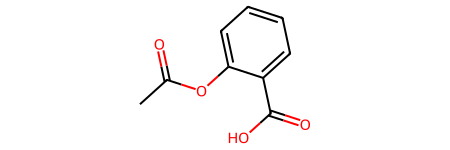

In [1]:
# 导入必备库
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors

# 1. 定义一个药物分子 (这是阿司匹林的 SMILES 编码)
# SMILES 是用字符串来表示化学结构的一种语言
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"

# 2. 把字符串变成 RDKit 的分子对象
mol = Chem.MolFromSmiles(aspirin_smiles)

# 3. 计算它的分子量 (Molecular Weight)
mol_weight = Descriptors.MolWt(mol)

# 4. 打印结果并画出分子
print(f"药物名称: 阿司匹林 (Aspirin)")
print(f"分子量: {mol_weight:.2f} g/mol")

# 这行代码会让分子图直接显示出来
mol

In [3]:
# 导入高级描述符计算模块
from rdkit.Chem import Descriptors
from rdkit.Chem import QED

# 1. 还是用我们的阿司匹林
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
mol = Chem.MolFromSmiles(aspirin_smiles)

# 2. 交互一：让 RDKit 告诉 AI，这个分子的“性格” (LogP)
# LogP 越高越亲油。口服药物通常要求 LogP 在 5 以下 (Lipinski 规则)。
logp_value = Descriptors.MolLogP(mol)

# 3. 交互二：让 RDKit 打分 (QED Score)
# QED (Quantitative Estimation of Drug-likeness) 范围是 0 到 1。
# 越接近 1，说明它越像一个成熟的上市药物。
qed_score = QED.qed(mol)

# 4. 打印“体检报告”
print(f"分子: 阿司匹林")
print(f"-------------------")
print(f"LogP (亲脂性): {logp_value:.2f}")
print(f"   -> 解读: 阿司匹林 LogP 约为 1.31，非常适合口服吸收。")
print(f"QED (成药性打分): {qed_score:.2f}")
print(f"   -> 解读: 分数很高，说明它在理化性质上是个完美的药物候选。")

# 5. (进阶) 如果这是 AI 生成的，我们会怎么做？
if qed_score > 0.6:
    print("判定结果: 这是一个好分子，保留！")
else:
    print("判定结果: 垃圾分子，丢弃。")

分子: 阿司匹林
-------------------
LogP (亲脂性): 1.31
   -> 解读: 阿司匹林 LogP 约为 1.31，非常适合口服吸收。
QED (成药性打分): 0.55
   -> 解读: 分数很高，说明它在理化性质上是个完美的药物候选。
判定结果: 垃圾分子，丢弃。


分子表示学习 (Molecular Representation Learning)

In [4]:
import torch
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

# 1. 模拟一个小数据集 (3个常用药：阿司匹林、布洛芬、咖啡因)
drug_data = [
    {"name": "Aspirin", "smiles": "CC(=O)OC1=CC=CC=C1C(=O)O"},
    {"name": "Ibuprofen", "smiles": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"},
    {"name": "Caffeine", "smiles": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"}
]

# 2. 批量把 SMILES 变成 Mol 对象
mols = [Chem.MolFromSmiles(d["smiles"]) for d in drug_data]

# 验证一下：看看是不是都转换成功了 (没有 None)
print(f"成功转换了 {len(mols)} 个分子。")

成功转换了 3 个分子。


In [5]:
# 3. 定义一个函数：把分子变成“0/1 向量”
def smile_to_vector(mol):
    # nBits=2048 是工业标准，意味着生成一个长度为 2048 的向量
    # radius=2 意味着考虑周围 2 个化学键范围内的原子环境 (类似 ECFP4)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    
    # 把 RDKit 的指纹对象转换成 Python 的 Numpy 数组
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# 4. 批量转换
vectors = [smile_to_vector(m) for m in mols]

# 看看转换后的结果长什么样
print(f"向量的形状: {vectors[0].shape}")
print(f"阿司匹林的前 20 位特征: {vectors[0][:20]}")
# 你会看到类似 [0. 0. 1. 0. ...] 这样的东西

向量的形状: (2048,)
阿司匹林的前 20 位特征: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
# 5. 转换为 PyTorch Tensor
# stack 是把多个向量堆叠成一个矩阵
tensor_data = torch.tensor(np.array(vectors), dtype=torch.float32)

print("=== 喂给 AI 的最终数据 ===")
print(f"数据类型: {type(tensor_data)}")
print(f"数据形状 (Batch_Size, Features): {tensor_data.shape}")
print("\n这就代表我们有了 [3, 2048] 的矩阵：")
print("3 行代表 3 个药物")
print("2048 列代表 2048 种化学子结构特征")

# 打印 Tensor 的基本信息
print("Tensor 的形状:", tensor_data.shape)  # 应该是 [3, 2048]
print("Tensor 的数据类型:", tensor_data.dtype) # 应该是 torch.float32

# 打印第一个分子（阿司匹林）的所有内容
# 因为 2048 太长，PyTorch 默认会省略中间的，只显示头尾
print(tensor_data[0]) 

# 咱们强制让它显示那些“被打成 1”的位置
# nonzero() 函数会告诉我们要找的 1 在哪
print("阿司匹林向量中，值为 1 的索引位置：")
print(tensor_data[0].nonzero().flatten())

=== 喂给 AI 的最终数据 ===
数据类型: <class 'torch.Tensor'>
数据形状 (Batch_Size, Features): torch.Size([3, 2048])

这就代表我们有了 [3, 2048] 的矩阵：
3 行代表 3 个药物
2048 列代表 2048 种化学子结构特征
Tensor 的形状: torch.Size([3, 2048])
Tensor 的数据类型: torch.float32
tensor([0., 0., 0.,  ..., 0., 0., 0.])
阿司匹林向量中，值为 1 的索引位置：
tensor([ 389,  456,  650,  695,  807,  909, 1017, 1035, 1047, 1057, 1088, 1199,
        1380, 1410, 1447, 1468, 1616, 1729, 1750, 1775, 1873, 1917, 1970, 1991])


如果只是用 Numpy 矩阵（Matrix/Array）：能做：简单的机器学习（如随机森林、SVM、XGBoost）；不能做：深度学习（神经网络）。

为什么要用 PyTorch Tensor？主要有两个“超能力”：

它在 GPU 上（加速），Numpy 矩阵只能在 CPU（内存）里，计算慢。Tensor 可以通过 .to('cuda') 一键搬家到显卡（显存）里。对于几百万个分子，GPU 比 CPU 快几十倍；它有记忆（自动求导 / Autograd）

当你训练 AI 时，需要反向传播（告诉模型怎么修改参数才能变聪明）。

Numpy：只是个计算器，算完 1+1=2 就忘了怎么算的。

Tensor：是个记账本。它不仅算出 2，还记得“这是由 A 和 B 相加得到的”。当你发出指令 loss.backward() 时，Tensor 能顺藤摸瓜把梯度传回去。

总结： 只要你想用神经网络（MLP, GNN, Transformer），你就必须把 Numpy 矩阵变成 Tensor。

In [7]:
# RDKit 自带的相似度计算
fp_aspirin = AllChem.GetMorganFingerprintAsBitVect(mols[0], 2, 2048)
fp_ibuprofen = AllChem.GetMorganFingerprintAsBitVect(mols[1], 2, 2048)
fp_caffeine = AllChem.GetMorganFingerprintAsBitVect(mols[2], 2, 2048)

sim_1 = DataStructs.TanimotoSimilarity(fp_aspirin, fp_ibuprofen)
sim_2 = DataStructs.TanimotoSimilarity(fp_aspirin, fp_caffeine)

print(f"阿司匹林 vs 布洛芬 相似度: {sim_1:.4f}")
print(f"阿司匹林 vs 咖啡因 相似度: {sim_2:.4f}")

阿司匹林 vs 布洛芬 相似度: 0.1951
阿司匹林 vs 咖啡因 相似度: 0.0889


In [9]:
pip install torch_geometric

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
     -------- ------------------------------- 0.3/1.3 MB ? eta -:--:--
     -------- ------------------------------- 0.3/1.3 MB ? eta -:--:--
     ---------------------------------------- 1.3/1.3 MB 2.5 MB/s  0:00:01

   --------------------- ------------------  6/11 [aiohappyeyeballs]
   -------------------------------- -------  9/11 [aiohttp]
   ------------------------------------ --- 10/11 [torch_geometric]
   ------------------------------------ --- 10/11 [torch_geometric]
   ------------------------------------ --- 10/11 [torch_geometric]
   ------------------------------------ --- 10/11 [torch_geometric]
   ------------------------------------ --- 10/11 [torch_geometric]
   ------------------------------------

In [10]:
import torch
from torch_geometric.data import Data
from rdkit import Chem

def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    
    # 1. 获取原子特征 (节点 Node Features)
    # 这里我们只用最简单的特征：原子序数 (C=6, O=8, N=7)
    # 形状: [原子数, 1]
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append([atom.GetAtomicNum()])
    x = torch.tensor(atom_features, dtype=torch.float)

    # 2. 获取化学键关系 (边 Edge Index)
    # PyG 要求 edge_index 是 [2, 边数] 的形状
    # 第一行是起点，第二行是终点
    rows, cols = [], []
    for bond in mol.GetBonds():
        start = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()
        # 因为是无向图，A连B 意味着 B也连A，要双向添加
        rows.extend([start, end])
        cols.extend([end, start])
    
    edge_index = torch.tensor([rows, cols], dtype=torch.long)

    # 3. 封装成 PyG 的 Data 对象
    data = Data(x=x, edge_index=edge_index)
    return data

# 测试：把阿司匹林变成图
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
graph_data = smile_to_graph(aspirin_smiles)

print("=== 阿司匹林的图结构数据 ===")
print(graph_data)
print(f"节点(原子)数量: {graph_data.num_nodes}")
print(f"边(化学键)数量: {graph_data.num_edges}") # 注意：双向边，所以数量是键数的2倍
print(f"节点特征 x 的形状: {graph_data.x.shape}")
print(f"边索引 edge_index 的形状: \n{graph_data.edge_index}")

=== 阿司匹林的图结构数据 ===
Data(x=[13, 1], edge_index=[2, 26])
节点(原子)数量: 13
边(化学键)数量: 26
节点特征 x 的形状: torch.Size([13, 1])
边索引 edge_index 的形状: 
tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 10, 12,  9,  4],
        [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 10,  4,  9]])


In [11]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class SimpleGNN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(SimpleGNN, self).__init__()
        # 定义层
        # 第一层 GCN: 输入特征 -> 64维隐藏特征
        self.conv1 = GCNConv(num_node_features, 64)
        # 第二层 GCN: 64维 -> 64维 (加深网络，捕获更远邻居)
        self.conv2 = GCNConv(64, 64)
        # 输出层: 64维 -> 1个数值 (比如 LogP)
        self.linear = torch.nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1. 第一轮消息传递
        x = self.conv1(x, edge_index)
        x = F.relu(x) # 激活函数
        
        # 2. 第二轮消息传递
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # 3. Readout (读出/池化)
        # 此时 x 的形状是 [原子数, 64]。我们需要一个代表"整个分子"的向量。
        # global_mean_pool 会对所有原子的特征取平均值。
        # 结果形状变为 [1, 64] (Batch Size, Hidden Dim)
        x = global_mean_pool(x, data.batch)

        # 4. 最终预测
        out = self.linear(x)
        return out

# 初始化模型
# 我们输入的特征维度是 1 (因为只用了原子序数)
model = SimpleGNN(num_node_features=1)
print(model)

SimpleGNN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader, Data
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import random

# === 1. 准备数据 (模拟 500 个分子) ===
# 我们用 RDKit 生成一些随机的 LogP 作为"真实标签"
def get_mol_data(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return None
    # 真实标签: LogP
    y = torch.tensor([[Descriptors.MolLogP(mol)]], dtype=torch.float)
    # 节点特征: 原子序数 (简单起见，只用这一个特征)
    x = torch.tensor([[atom.GetAtomicNum()] for atom in mol.GetAtoms()], dtype=torch.float)
    # 边索引
    rows, cols = [], []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        rows.extend([start, end]); cols.extend([end, start])
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

# 造一些数据
base_smiles = ["C", "CC", "CCC", "C(=O)O", "C1CCCCC1", "c1ccccc1", "CO", "CN", "F", "Cl"]
dataset = []
print("正在生成数据...")
for _ in range(200): # 生成200个随机组合的分子
    s = ".".join(random.choices(base_smiles, k=random.randint(2, 5)))
    data = get_mol_data(s)
    if data: dataset.append(data)

loader = DataLoader(dataset, batch_size=16, shuffle=True)
print(f"准备完毕! 数据集大小: {len(dataset)}")

# === 2. 定义 GCN 模型 ===
class SimpleGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 这里的 64 就是你刚才问的"超参数"
        self.conv1 = GCNConv(1, 64) 
        self.conv2 = GCNConv(64, 64)
        self.linear = torch.nn.Linear(64, 1) # 输出 LogP

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index)) # 投影+混合+激活
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)        # 压缩成 1 行
        return self.linear(x)                 # 线性预测

model = SimpleGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # 学习率
criterion = torch.nn.MSELoss() # 均方误差 (Mean Squared Error)

正在生成数据...
准备完毕! 数据集大小: 200


C:\Users\rasca\AppData\Local\Temp\ipykernel_22884\1268259717.py:36: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(dataset, batch_size=16, shuffle=True)


=== 开始训练 (观察 Loss 是如何下降的) ===
Epoch 00 | Loss: 4.6553
Epoch 10 | Loss: 3.5407
Epoch 20 | Loss: 3.2855
Epoch 30 | Loss: 2.7374
Epoch 40 | Loss: 1.8440
Epoch 50 | Loss: 1.5992


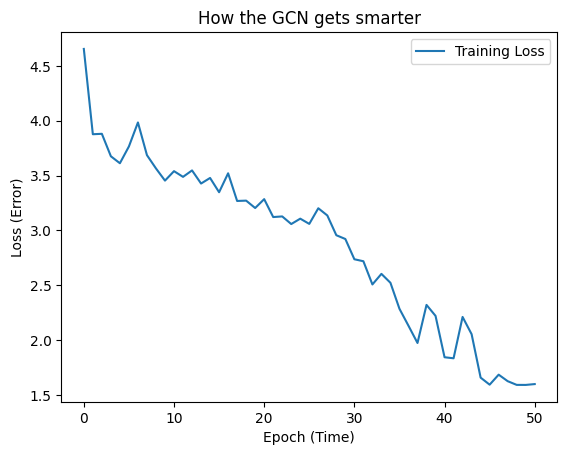

In [14]:
losses = []  # 记录每一轮的 Loss，用来画图

print("=== 开始训练 (观察 Loss 是如何下降的) ===")
model.train()

for epoch in range(51): # 训练 50 轮
    total_loss = 0
    for batch in loader:
        # 1. 梯度清零
        # (把上一轮算出来的"整改意见"删掉，重新开始)
        optimizer.zero_grad()
        
        # 2. 正向传播 (模型猜结果)
        pred = model(batch)
        
        # 3. 计算损失 (和真实 LogP 比，差了多少？)
        loss = criterion(pred, batch.y)
        
        # 4. 反向传播 (最关键的一步！)
        # PyTorch 会自动计算每个权重 w 对 loss 的贡献
        loss.backward()
        
        # 5. 更新权重
        # 优化器根据梯度，修改所有 w 的值 (让 w 往正确的方向挪一点点)
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    losses.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d} | Loss: {avg_loss:.4f}")

# === 画出学习曲线 ===
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch (Time)')
plt.ylabel('Loss (Error)')
plt.title('How the GCN gets smarter')
plt.legend()
plt.show()

In [15]:
model.eval() # 切换到考试模式

# 阿司匹林的真实 SMILES
aspirin_smi = "CC(=O)OC1=CC=CC=C1C(=O)O"
test_data = get_mol_data(aspirin_smi)

# 真实值
true_val = test_data.y.item()

# 预测值
with torch.no_grad():
    pred_val = model(test_data).item()

print(f"\n=== 最终测试: 阿司匹林 ===")
print(f"真实 LogP: {true_val:.4f}")
print(f"预测 LogP: {pred_val:.4f}")
print(f"误差: {abs(true_val - pred_val):.4f}")

if abs(true_val - pred_val) < 0.5:
    print("✅ 成功！模型学会了预测亲脂性！")
else:
    print("⚠️ 还需要更多训练数据！")


=== 最终测试: 阿司匹林 ===
真实 LogP: 1.3101
预测 LogP: 1.8169
误差: 0.5068
⚠️ 还需要更多训练数据！
